In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
# sklearn 
from sklearn import set_config
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, average_precision_score
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
# xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

%matplotlib inline
sns.set_style("dark")  # darkgrid, whitegrid, dark, white, ticks

In [2]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Feature selection as part of a pipeline.

Meta-transformer for selecting features based on importance weights

In [3]:
def undersample(df):
    # Undersampling by selecting a sample size of non-fraud items equal to the length of the fraud items.
    fraud_df = df[df['isFraud'] == 1]
    non_fraud_df = df[df['isFraud'] == 0]

    non_fraud_df = non_fraud_df.sample(n=len(fraud_df))
    df = pd.concat([fraud_df, non_fraud_df])
    df = df.sample(frac=1)
    return df

df = undersample(df)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4388717,315,CASH_OUT,5863.97,C2090380520,5863.97,0.0,C1941943656,0.00,5863.97,1,0
3705763,277,CASH_OUT,269353.84,C1476576326,755.00,0.0,C1848831171,71179.77,340533.61,0,0
3199995,249,TRANSFER,90915.00,C1794988731,90915.00,0.0,C1111485677,0.00,0.00,1,0
2885637,228,PAYMENT,2549.20,C1270148128,54262.29,51713.1,M399579352,0.00,0.00,0,0
5692078,397,PAYMENT,6319.76,C95584146,0.00,0.0,M746998953,0.00,0.00,0,0


In [4]:
def preprocessing(df):
    df['errorBalanceOrg'] = df.amount + df.newbalanceOrig - df.oldbalanceOrg 
    df['errorBalanceDest'] = df.amount + df.newbalanceDest - df.oldbalanceDest
    df.loc[(df.oldbalanceDest == 0) & (df.newbalanceDest == 0) & df.amount, ['oldbalanceDest', 'newbalanceDest']] = - 1
    one_hot = pd.get_dummies(df['type'])
    df = df.join(one_hot)
    df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'type'], inplace=True)    
    return df

df = preprocessing(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4388717,315,5863.97,5863.97,0.0,0.00,5863.97,1,0.00,11727.94,0,1,0,0,0
3705763,277,269353.84,755.00,0.0,71179.77,340533.61,0,268598.84,538707.68,0,1,0,0,0
3199995,249,90915.00,90915.00,0.0,-1.00,-1.00,1,0.00,90915.00,0,0,0,0,1
2885637,228,2549.20,54262.29,51713.1,-1.00,-1.00,0,0.01,2549.20,0,0,0,1,0
5692078,397,6319.76,0.00,0.0,-1.00,-1.00,0,6319.76,6319.76,0,0,0,1,0


In [5]:
X = df.loc[:, df.columns != 'isFraud']
y = df.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
feature_names = X_train.columns

In [6]:
model = RandomForestClassifier()

def modelPipline(model):
    # define model Pipeline
    return Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classification', model)
    ])

model_pipeline = modelPipline(model)

In [7]:
set_config(display="diagram")
model_pipeline  # click on the diagram below to see the details of each step

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('classification', RandomForestClassifier())])

In [8]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.998


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        print("Train Result:\n================================================")
        print(f"Accuracy Score:      {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score:   {precision_score(y_train, pred) * 100:.2f}%")
        print(f"\t\t\tRecall Score:  {recall_score(y_train, pred) * 100:.2f}%")
        print(f"\t\t\tF1 score:      {f1_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score:     {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score:  {precision_score(y_test, pred) * 100:.2f}%")
        print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
        print(f"\t\t\tF1 score:     {f1_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n") 

Train Result:
Accuracy Score:      100.00%
_______________________________________________
Classification Report:	Precision Score:   100.00%
			Recall Score:  100.00%
			F1 score:      100.00%
_______________________________________________
Confusion Matrix: 
 [[5749    0]
 [   0 5749]]

Test Result:
Accuracy Score:     99.76%
_______________________________________________
Classification Report:	Precision Score:  99.72%
			Recall Score: 99.80%
			F1 score:     99.76%
_______________________________________________
Confusion Matrix: 
 [[2457    7]
 [   5 2459]]



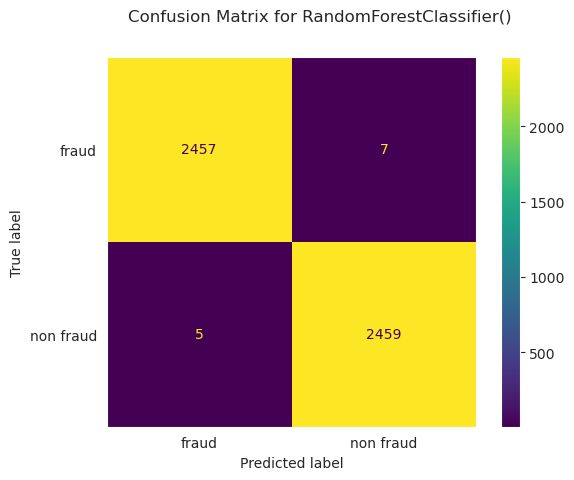

In [10]:
model_pipeline.fit(X_train, y_train)
print_score(model_pipeline, X_train, y_train, X_test, y_test, train=True)
print_score(model_pipeline, X_train, y_train, X_test, y_test, train=False)
fig = ConfusionMatrixDisplay.from_estimator( model_pipeline, X_test, y_test, display_labels=["fraud","non fraud"])
fig.figure_.suptitle(f"Confusion Matrix for {str(model)}")
plt.show()

Examine several machine learning models

Train Result:
Accuracy Score:      89.51%
_______________________________________________
Classification Report:	Precision Score:   96.44%
			Recall Score:  82.05%
			F1 score:      88.67%
_______________________________________________
Confusion Matrix: 
 [[5575  174]
 [1032 4717]]

Test Result:
Accuracy Score:     89.94%
_______________________________________________
Classification Report:	Precision Score:  96.81%
			Recall Score: 82.59%
			F1 score:     89.14%
_______________________________________________
Confusion Matrix: 
 [[2397   67]
 [ 429 2035]]



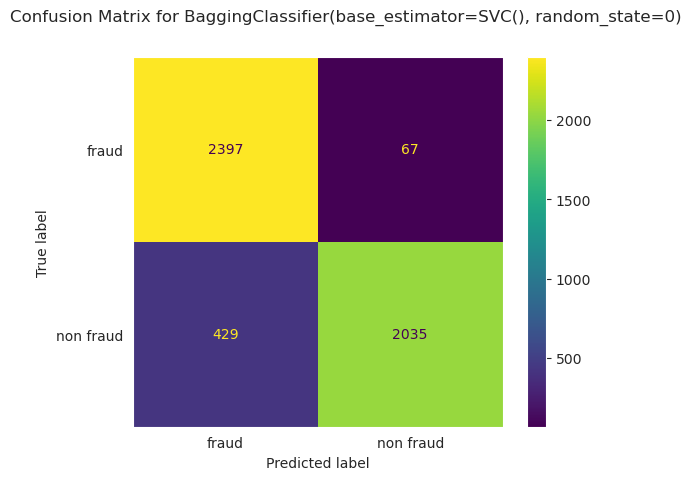

Train Result:
Accuracy Score:      99.94%
_______________________________________________
Classification Report:	Precision Score:   100.00%
			Recall Score:  99.88%
			F1 score:      99.94%
_______________________________________________
Confusion Matrix: 
 [[5749    0]
 [   7 5742]]

Test Result:
Accuracy Score:     99.80%
_______________________________________________
Classification Report:	Precision Score:  99.80%
			Recall Score: 99.80%
			F1 score:     99.80%
_______________________________________________
Confusion Matrix: 
 [[2459    5]
 [   5 2459]]



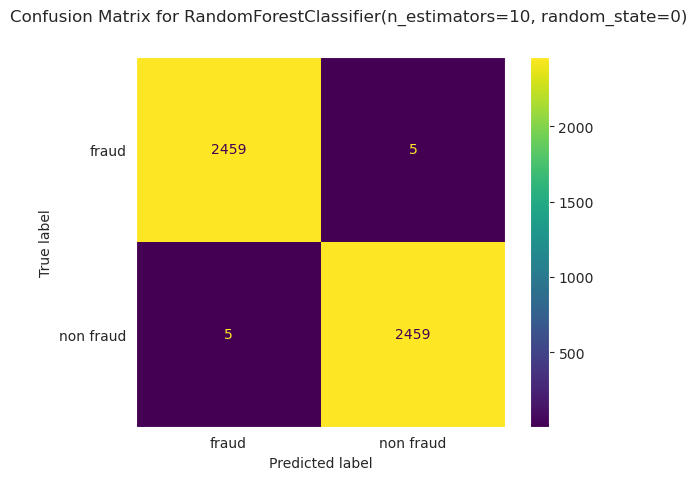

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Train Result:
Accuracy Score:      87.48%
_______________________________________________
Classification Report:	Precision Score:   95.18%
			Recall Score:  78.97%
			F1 score:      86.32%
_______________________________________________
Confusion Matrix: 
 [[5519  230]
 [1209 4540]]

Test Result:
Accuracy Score:     88.23%
_______________________________________________
Classification Report:	Precision Score:  96.18%
			Recall Score: 79.63%
			F1 score:     87.12%
_______________________________________________
Confusion Matrix: 
 [[2386   78]
 [ 502 1962]]



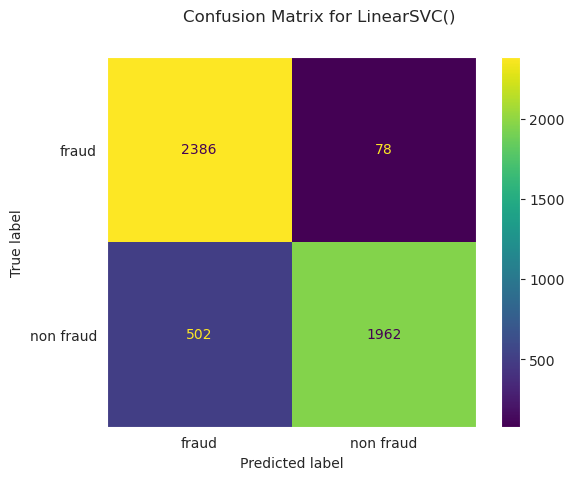

Train Result:
Accuracy Score:      89.53%
_______________________________________________
Classification Report:	Precision Score:   96.48%
			Recall Score:  82.05%
			F1 score:      88.68%
_______________________________________________
Confusion Matrix: 
 [[5577  172]
 [1032 4717]]

Test Result:
Accuracy Score:     89.85%
_______________________________________________
Classification Report:	Precision Score:  96.85%
			Recall Score: 82.39%
			F1 score:     89.04%
_______________________________________________
Confusion Matrix: 
 [[2398   66]
 [ 434 2030]]



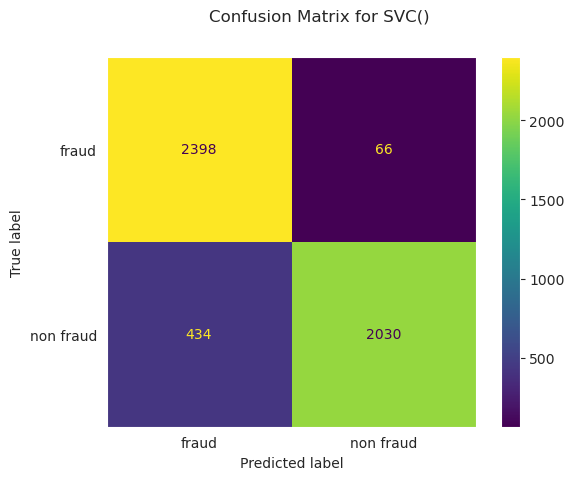

Train Result:
Accuracy Score:      99.50%
_______________________________________________
Classification Report:	Precision Score:   99.60%
			Recall Score:  99.39%
			F1 score:      99.50%
_______________________________________________
Confusion Matrix: 
 [[5726   23]
 [  35 5714]]

Test Result:
Accuracy Score:     99.72%
_______________________________________________
Classification Report:	Precision Score:  99.72%
			Recall Score: 99.72%
			F1 score:     99.72%
_______________________________________________
Confusion Matrix: 
 [[2457    7]
 [   7 2457]]



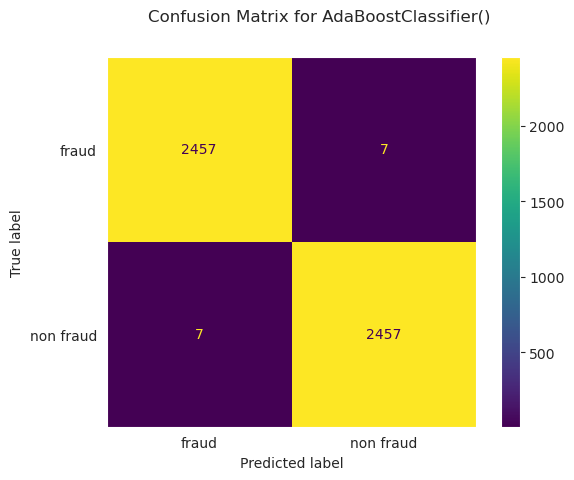

Train Result:
Accuracy Score:      87.29%
_______________________________________________
Classification Report:	Precision Score:   95.95%
			Recall Score:  77.87%
			F1 score:      85.97%
_______________________________________________
Confusion Matrix: 
 [[5560  189]
 [1272 4477]]

Test Result:
Accuracy Score:     87.93%
_______________________________________________
Classification Report:	Precision Score:  96.47%
			Recall Score: 78.73%
			F1 score:     86.70%
_______________________________________________
Confusion Matrix: 
 [[2393   71]
 [ 524 1940]]



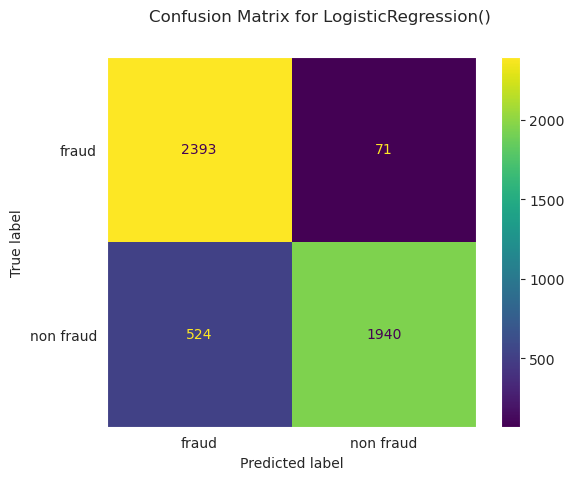

In [11]:
classifiers = [
    BaggingClassifier(SVC(), n_estimators=10, random_state=0),
    RandomForestClassifier(n_estimators=10, random_state=0),
    LinearSVC(),
    SVC(),
    AdaBoostClassifier(),
    LogisticRegression()
]

for model in classifiers:
    model_pipeline = modelPipline(model)
    model_pipeline.fit(X_train, y_train)
    print_score(model_pipeline, X_train, y_train, X_test, y_test, train=True)
    print_score(model_pipeline, X_train, y_train, X_test, y_test, train=False)
    fig = ConfusionMatrixDisplay.from_estimator( model_pipeline, X_test, y_test, display_labels=["fraud","non fraud"])
    fig.figure_.suptitle(f"Confusion Matrix for {str(model)}")
    plt.show()

## XGBClassifier

In [12]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())
XGBmodel = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
XGBmodel.fit(X_train, y_train)

predict_proba = XGBmodel.predict_proba(X_test)
print(f"AUPRC = {average_precision_score(y_test,  predict_proba[:, 1])}")

AUPRC = 0.9996920837548975


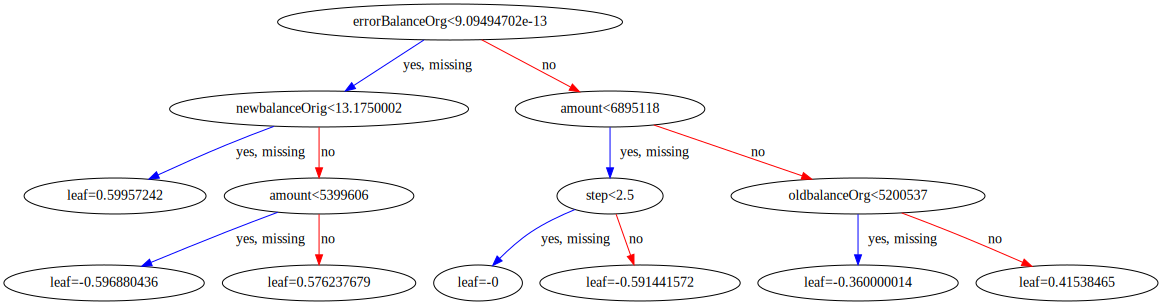

In [13]:
to_graphviz(XGBmodel)

In [14]:
train_sizes, train_scores, crossValScores = learning_curve(
    XGBmodel, 
    X_train,
    y_train, 
    scoring = 'average_precision'
)

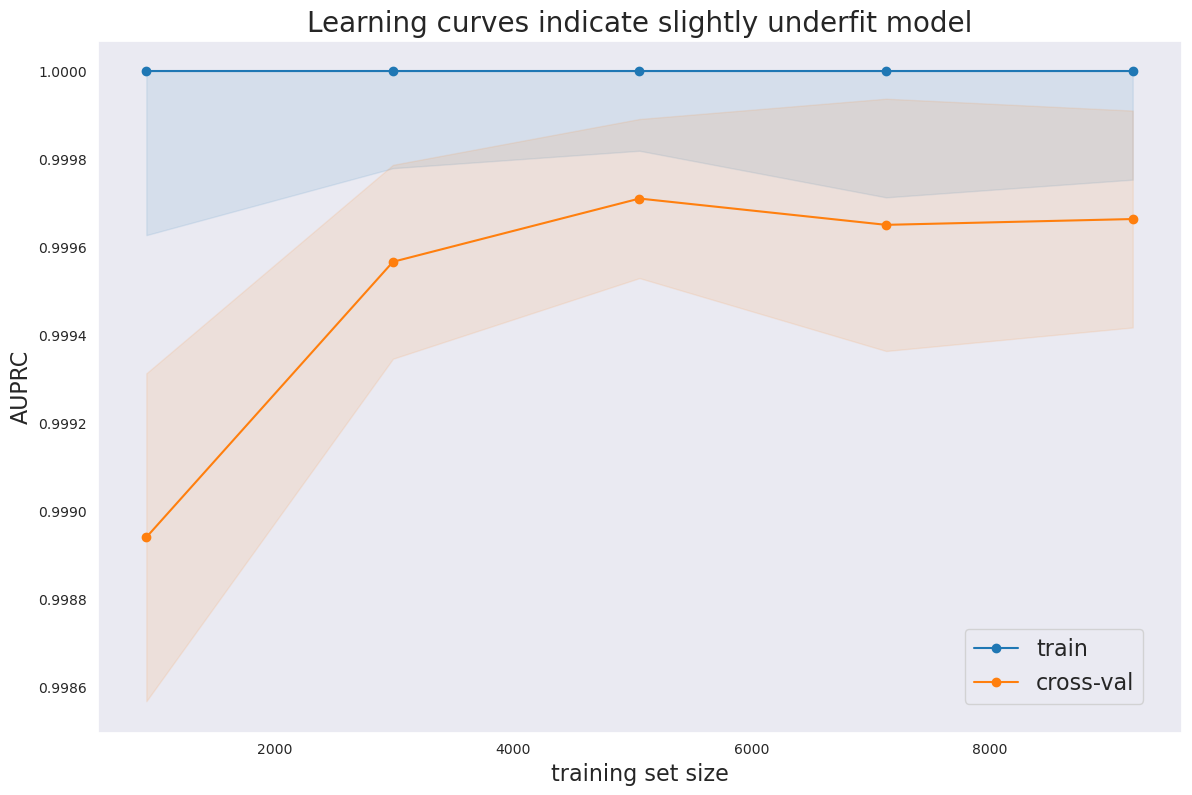

In [15]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
crossValScores_mean = np.mean(crossValScores, axis=1)
crossValScores_std = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(train_sizes, train_scores_mean - crossValScores_std, train_scores_mean + train_scores_std, alpha=0.1, color=colours[0])
plt.fill_between(train_sizes, crossValScores_mean - crossValScores_std, crossValScores_mean + crossValScores_std, alpha=0.1, color=colours[1])
plt.plot(train_sizes, train_scores.mean(axis = 1), 'o-', label = 'train', color = colours[0])
plt.plot(train_sizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val',  color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);